# Lid-driven Cavity Flow using the Projection Method

## Introduction 

Consider the 2D incompressible Navier-Stokes equations (also known as momentum equations)

\begin{align}
& \frac{\partial u}{\partial t}+u \cdot \frac{\partial u}{\partial x}+v \cdot \frac{\partial u}{\partial y}=-\frac{1}{\rho} \frac{\partial p}{\partial x}+\nu \frac{\partial^2 u}{\partial x^2}+\nu \frac{\partial^2 u}{\partial y^2}, \\
& \frac{\partial v}{\partial t}+u \cdot \frac{\partial v}{\partial x}+v \cdot \frac{\partial v}{\partial y}=-\frac{1}{\rho} \frac{\partial p}{\partial y}+\nu \frac{\partial^2 v}{\partial x^2}+\nu \frac{\partial^2 v}{\partial y^2},
\end{align}

and the continuity equation

\begin{equation}
\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}=0,
\end{equation}

where $\mathbf{u} = (u,v)$ are flow velocities  in $x,y$ direction, $\rho$ is the density (constant for incompressible flow), $\nu$ is the kinematic viscosity, and $p$ stands for pressure.
One can write them into a more compact form (dimension free) as 

\begin{align}
\frac{\partial \mathbf{u}}{\partial t}+(\mathbf{u} \cdot \nabla) \mathbf{u}&= -\frac{1}{\rho} \nabla p+\nu \nabla^2 \mathbf{u}, \\
\nabla \cdot \mathbf{u} & =0.
\end{align}

---

### Staggered Grid

To deal with the checkerboard pressure problem, we assign different mesh systems to each primitive  variables $u,v,p$ as following.


<p align="center">
  <a href="https://www.cfd-online.com/Wiki/Staggered_grid">
    <img width=50% src="./Gallery/staggered_grid.png">
  </a>
</p>

The pressure is stored at the cell center and the velocities are stored at the cell faces.

---

### Chorin's Projection Method

The algorithm adopts an operator splitting approach in which one considers the viscous forces (in the first half step) and the pressure forces (in the second half step) separately. A distinguishing feature of Chorin's projection method is that the velocity field is forced to satisfy a discrete continuity constraint at the end of each time step.

We first discretize the time domain using an explicit Euler scheme

\begin{equation}
\frac{\mathbf{u}^{n+1}-\mathbf{u}^n}{\Delta t}=-\frac{1}{\rho} \nabla p^{n+1}-\left(\mathbf{u}^n \cdot \nabla\right) +\nu \nabla^2 \mathbf{u}^n,
\end{equation}

where the time-step $\Delta t$ should be chosen so that $u \Delta t / \Delta x<1$ to satisfy the Courant-Friedrichs-Lewy (CFL) condition.

**Step I: Predictor step** \
Computes an intermediate velocity ${\mathbf  {u}}^{*}$, explicitly using the momentum equation by ignoring the pressure gradient term $\nabla p^{n+1} = 0$:

\begin{align}
\frac{\mathbf{u}^*-\mathbf{u}^n}{\Delta t} = -\left(\mathbf{u}^n \cdot \nabla\right) \mathbf{u}^n+\nu \nabla^2 \mathbf{u}^n, 
\end{align}

where $\mathbf{u}^n$ is the velocity at $n^{\text {th }}$ time step. 

**Step II: Projection step** \
We correct the intermediate velocity to obtain the final solution of the time step $\mathbf{u}^{n+1}$ 

\begin{equation}
\frac{\mathbf{u}^{n+1}-\mathbf{u}^*}{\Delta t}=-\frac{1}{\rho} \nabla p^{n+1}.
\end{equation}

**Step III: Pressure Poisson equation** \
Considering the divergence (continuity) condition at the next time step $t=n+1$, we have

\begin{align}
\nabla \cdot \mathbf{u}^{n+1} = 0
\quad \Rightarrow \quad
\nabla \cdot \bigg(\mathbf{u}^*-\frac{\Delta t}{\rho} \nabla p^{n+1} \bigg) = 0.
\end{align}

Reorganize it to obtain a Poisson problem

\begin{align}
\boxed{\nabla^2 p^{n+1}=\frac{\rho}{\Delta t} \nabla \cdot \mathbf{u}^*.}
\end{align}

**Step IV: Velocity correction** \
Once we solve the Poisson problem, we can correct the velocity from ${\mathbf  {u}}^{*}$ to the next time step $\mathbf{u}^{n+1}$ 
\begin{align}
\mathbf{u}^{n+1}=\mathbf{u}^*-\frac{\Delta t}{\rho} \nabla p^{n+1}.
\end{align}

---

## Algorithm

The code below follows this guide https://www.montana.edu/mowkes/research/source-codes/GuideToCFD.pdf


In [144]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Lx = 1              # length of domian in x-direction
Ly = 1              # length of domian in y-direction
nx = 30             # grid size in x-direction
ny = 30             # grid size in y-direction

Re = 100            # Reynolds number
nu = 1/Re           # kinematic viscosity
rho = 1.0           # density
dt = 0.01          # time step size
itr = 5000          # iterations
velocity = 1.0


# Create staggered grid index system
imin, jmin = 1, 1
imax = imin + nx - 1
jmax = jmin + ny - 1

# Define ghost cells for boundary conditions
x = np.zeros(jmax + 2)
y = np.zeros(jmax + 2)
x[imin: imax + 2] = np.linspace(0, Lx, nx + 1, endpoint=True)
y[jmin: jmax + 2] = np.linspace(0, Ly, ny + 1, endpoint=True)

dx = x[imin + 1] - x[imin]
dy = y[jmin + 1] - y[jmin]
dxi = 1 / dx
dyi = 1 / dy

# Variable declaration
u = np.zeros((imax + 2, jmax + 2))
v = np.zeros((imax + 2, jmax + 2))


def boundary_condition(u, v):
    u[imin, jmin - 1:jmax + 1] = 0
    u[imax + 1, jmin - 1:jmax + 1] = 0
    u[imin: imax + 2, jmin - 1] = -u[imin: imax + 2, jmin]
    u[imin: imax + 2, jmax + 1] = 2 - u[imin: imax + 2, jmax]


    v[imin - 1: imax + 2, jmin] = 0.
    v[imin - 1: imax + 2, jmax + 1] = 0.
    v[imin - 1, jmin:jmax + 1] = -v[imin, jmin:jmax + 1]
    v[imax + 1, jmin:jmax + 1] = -v[imax, jmin:jmax + 1]


for _ in tqdm(range(itr)):
    
    # u-momentum
    us = u.copy()
    I = slice(imin + 1, imax + 1)
    Ib = slice(imin, imax)
    If = slice(imin + 2, imax + 2)


    J = slice(jmin, jmax + 1)
    Jb = slice(jmin - 1, jmax)
    Jf = slice(jmin + 1, jmax + 2)


    v_here = 0.25 * (v[Ib, J] + v[Ib, Jf] + v[I, J] + v[I, Jf])
    us[I, J] = u[I, J] + dt * (
            nu * (u[Ib, J] - 2 * u[I, J] + u[If, J]) * dxi ** 2
            + nu * (u[I, Jb] - 2 * u[I, J] + u[I, Jf]) * dyi ** 2
            - v_here * (u[I, Jf] - u[I, Jb]) * 0.5 * dyi
            - u[I, J] * (u[If, J] - u[Ib, J]) * 0.5 * dxi
    )

    

    # v-momentum
    vs = v.copy()
    I = slice(imin, imax + 1)
    Ib = slice(imin - 1, imax)
    If = slice(imin + 1, imax + 2)


    J = slice(jmin + 1, jmax + 1)
    Jb = slice(jmin, jmax)
    Jf = slice(jmin + 2, jmax + 2)


    u_here = 0.25 * (u[I, Jb] + u[I, J] + u[If, Jb] + u[If, J])
    vs[I, J] = v[I, J] + dt * (
            nu * (v[Ib, J] - 2 * v[I, J] + v[If, J]) * dxi ** 2
            + nu * (v[I, Jb] - 2 * v[I, J] + v[I, Jf]) * dyi ** 2
            - u_here * (v[If, J] - v[Ib, J]) * 0.5 * dxi
            - v[I, J] * (v[I, Jf] - v[I, Jb]) * 0.5 * dyi
    )


    # Claculate R.H.S of pressure Poisson
    Rn = -rho / dt * ((us[imin + 1: imax + 2, jmin: jmax + 1]
                       - us[imin: imax + 1, jmin: jmax + 1]) * dxi
                      + (vs[imin: imax + 1, jmin + 1: jmax + 2]
                       - vs[imin: imax + 1, jmin: jmax + 1]) * dyi)
    
    R = Rn.T.ravel()
    pv = np.linalg.solve(L, R)
    pn = pv.reshape(ny, nx).T
    p = np.zeros((imax + 1, jmax + 1))
    p[1:, 1:] = pn
    p[0, 0] = 0


    # Correct velocity
    u[imin + 1: imax + 1, jmin: jmax + 1] = us[imin + 1: imax + 1, jmin: jmax + 1] - dt / rho * (
                p[imin + 1: imax + 1, jmin: jmax + 1] - p[imin: imax, jmin: jmax + 1]) * dxi
    v[imin: imax + 1, jmin + 1: jmax + 1] = vs[imin: imax + 1, jmin + 1: jmax + 1] - dt / rho * (
                p[imin: imax + 1, jmin + 1: jmax + 1] - p[imin: imax + 1, jmin: jmax]) * dyi
    
#     boundary_condition(u, v)
    # Update BCs
    v[imin,:] = 0.0                   # left wall
    v[imax+1,:] = 0.0                 # right wall
#     v[:, jmin-1] = -v[:, jmin]      # bottom wall
#     v[:, jmax+1] = -v[:, jmax]      # top wall

#     u[imin-1, :] = -u[imin, :]      # left wall
#     u[imax+1, :] = -u[imax, :]      # right wall
    u[:,0] = 0.0                      # bottom wall
    u[:,imax+1] = velocity            # top wall

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:05<00:00, 76.83it/s]


In [ ]:
def boundary_condition(u, v):
    u[imin, jmin - 1:jmax + 1] = 0         # left wall
    u[imax + 1, jmin - 1:jmax + 1] = 0     # right wall
    u[imin: imax + 2, jmin - 1] = -u[imin: imax + 2, jmin]      # bottom wall
    u[imin: imax + 2, jmax + 1] = 2 - u[imin: imax + 2, jmax]   # top wall


    v[imin - 1: imax + 2, jmin] = 0.
    v[imin - 1: imax + 2, jmax + 1] = 0.
    v[imin - 1, jmin:jmax + 1] = -v[imin, jmin:jmax + 1]
    v[imax + 1, jmin:jmax + 1] = -v[imax, jmin:jmax + 1]

In [87]:
u.shape

(32, 32)

In [124]:
y

array([0.        , 0.        , 0.03333333, 0.06666667, 0.1       ,
       0.13333333, 0.16666667, 0.2       , 0.23333333, 0.26666667,
       0.3       , 0.33333333, 0.36666667, 0.4       , 0.43333333,
       0.46666667, 0.5       , 0.53333333, 0.56666667, 0.6       ,
       0.63333333, 0.66666667, 0.7       , 0.73333333, 0.76666667,
       0.8       , 0.83333333, 0.86666667, 0.9       , 0.93333333,
       0.96666667, 1.        ])

In [106]:
u[imin-1,:]

array([ 0.00000000e+00,  1.57401354e-04,  1.82844508e-04,  1.54469684e-04,
        1.16549078e-04,  8.85772728e-05,  7.44783391e-05,  7.13321627e-05,
        7.41826777e-05,  7.78304604e-05,  7.70773523e-05,  6.63191781e-05,
        3.88815920e-05, -1.37807682e-05, -1.03045346e-04, -2.44401228e-04,
       -4.59463305e-04, -7.79674607e-04, -1.25362163e-03, -1.96130042e-03,
       -3.04001298e-03, -4.72607076e-03, -7.40988696e-03, -1.16809729e-02,
       -1.82894556e-02, -2.78506975e-02, -3.99429310e-02, -5.09351850e-02,
       -4.89093554e-02,  1.30811721e-03,  2.15111795e-01,  1.00000000e+00])

The Laplacian only depends on the computational mesh and can be computed once at the beginning of the simulation and stored.

In [130]:
def Laplacian(nx, ny, dxi, dyi):
    Dx = np.diag(np.ones(nx)) * 2 - np.diag(np.ones(nx - 1), 1) - np.diag(np.ones(nx - 1), -1)
    Dx[0, 0] = 1
    Dx[-1, -1] = 1
    Ix = np.diag(np.ones(ny))
    Dy = np.diag(np.ones(ny)) * 2 - np.diag(np.ones(ny - 1), 1) - np.diag(np.ones(ny - 1), -1)
    Dy[0, 0] = 1
    Dy[-1, -1] = 1
    Iy = np.diag(np.ones(nx))
    L = np.kron(Ix, Dx) * dxi ** 2 + np.kron(Dy, Iy) * dyi ** 2
    return L

L = Laplacian(nx, ny, dxi, dyi)

In [131]:
L

array([[1800., -900.,    0., ...,    0.,    0.,    0.],
       [-900., 2700., -900., ...,    0.,    0.,    0.],
       [   0., -900., 2700., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ..., 2700., -900.,    0.],
       [   0.,    0.,    0., ..., -900., 2700., -900.],
       [   0.,    0.,    0., ...,    0., -900., 1800.]])

In [138]:
L[0,0]=1
# L[0,1]=0
# L[0,nx]=0
L

array([[ 1.0e+00, -9.0e+02,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [-9.0e+02,  2.7e+03, -9.0e+02, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 0.0e+00, -9.0e+02,  2.7e+03, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       ...,
       [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  2.7e+03, -9.0e+02,  0.0e+00],
       [ 0.0e+00,  0.0e+00,  0.0e+00, ..., -9.0e+02,  2.7e+03, -9.0e+02],
       [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00, -9.0e+02,  1.8e+03]])

Matrix Condition Number =  10955.629974412823


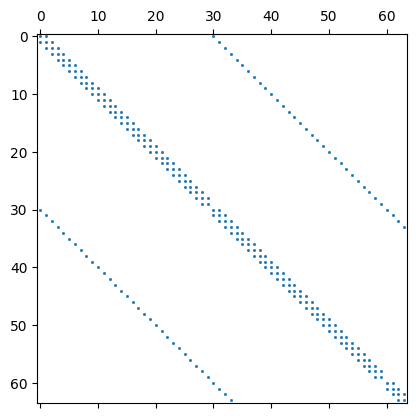

In [139]:
# Check sparse pattern
print("Matrix Condition Number = ", np.linalg.cond(L))
plt.spy(L[0:64, 0:64], markersize=1)
plt.show()

## Benchmark

In [119]:
u[imin: imax + 2, 0].shape

(31,)

In [121]:
imax

30

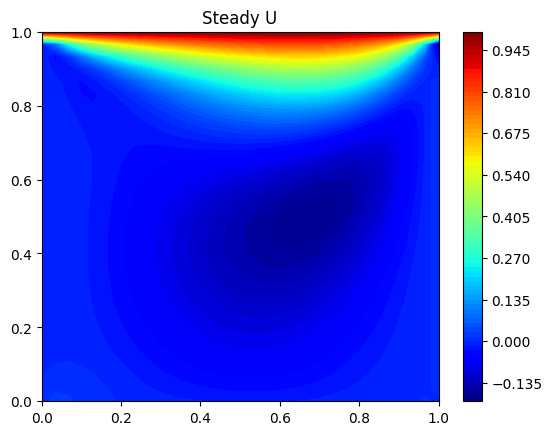

In [145]:
X, Y = np.meshgrid(x, y)
plt.figure()
plt.contourf(X, Y, u.T, 80, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady U")
plt.show()

In [55]:
GhiaU = np.loadtxt('./benchmark/GhiaU.txt', skiprows=1)
GhiaV = np.loadtxt('./benchmark/GhiaV.txt', skiprows=1)
y_Ghia = GhiaU[:, 0]
x_Ghia = GhiaV[:, 0]

In [56]:
# Understand what's inside the benchmark data
import pandas as pd
# pd.set_option('display.max_columns', None)
df = pd.read_table("./benchmark/GhiaU.txt", skiprows=0, delimiter='\r')
print(df)

   # Ghia, U. K. N. G., Ghia, K. N., & Shin, C. T. (1982). 
0   # High-Re solutions for incompressible flow us...      
1   # Journal of computational physics, 48(3), 387...      
2                                                   #      
3                                           # TABLE I      
4   # Results for $u$-velocity along Vertical Line...      
5   #---------------------------------------------...      
6              #                                   Re      
7   #       --------------------------------------...      
8   #  y      100      400      1000     3200     ...      
9   #---------------------------------------------...      
10  1.0000  1.00000  1.00000  1.00000  1.00000  1....      
11  0.9766  0.84123  0.75837  0.65928  0.53236  0....      
12  0.9688  0.78871  0.68439  0.57492  0.48296  0....      
13  0.9609  0.73722  0.61756  0.51117  0.46547  0....      
14  0.9531  0.68717  0.55892  0.46604  0.46101  0....      
15  0.8516  0.23151  0.29093  0.33304  0

In [80]:
u[15,:]

array([ 1.05741409e-02, -1.05741409e-02, -2.88779388e-02, -4.52459782e-02,
       -6.03865153e-02, -7.48417707e-02, -8.90033748e-02, -1.03113212e-01,
       -1.17253826e-01, -1.31333131e-01, -1.45069310e-01, -1.57983141e-01,
       -1.69405888e-01, -1.78510534e-01, -1.84371602e-01, -1.86053442e-01,
       -1.82718871e-01, -1.73740789e-01, -1.58791448e-01, -1.37880039e-01,
       -1.11310102e-01, -7.95308016e-02, -4.28535315e-02, -9.91928959e-04,
        4.76310339e-02,  1.06831016e-01,  1.83692252e-01,  2.89006424e-01,
        4.35641869e-01,  6.32725996e-01,  8.74312722e-01,  1.12568728e+00])

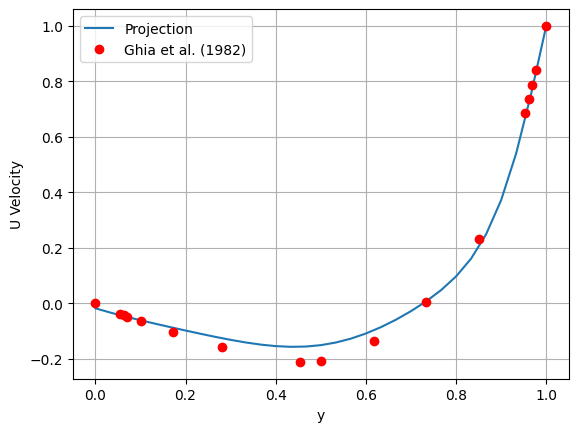

In [137]:
plt.plot(y, u[15,:], label="Projection")
plt.plot(y_Ghia, GhiaU[:, 1], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
plt.legend()


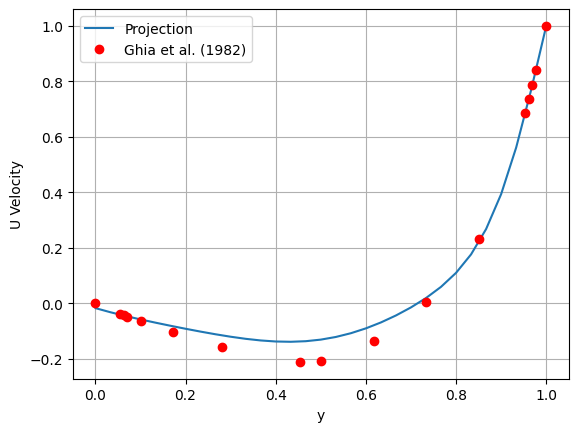

In [146]:
plt.plot(y, u[15,:], label="Projection")
plt.plot(y_Ghia, GhiaU[:, 1], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
plt.legend()